In [1]:
%load_ext autoreload
%autoreload 2

In [12]:
import os
import json
import glob
import config
import re
import jax.numpy as jnp
import nicewebrl
from typing import List
from collections import defaultdict
from flax import serialization
import polars as pl
from glob import glob

import xminigrid
import jax

import config
from download_google_data import download_user_files
from experiment_structure import PlaygroundTimestepWrapper, actions, render_fn
from nicewebrl import JaxWebEnv

rng: jax.random.PRNGKey = jax.random.key(42)

def make_env_objects(name='small-1m'):
    env, env_params = xminigrid.make("XLand-MiniGrid-R1-9x9")
    jax_env = PlaygroundTimestepWrapper(env, autoreset=False, use_params=True)
    jax_web_env = JaxWebEnv(
        env=jax_env,
        actions=actions,
        render_fn=render_fn,
    )
    # NOTE: we need different compiled functions per setting, because the diffrent benchmarks use pytrees with different shapes
    benchmark = xminigrid.load_benchmark(name=name)
    rule = benchmark.sample_ruleset(rng)
    env_params = env_params.replace(ruleset=rule)
    jax_web_env.precompile(dummy_env_params=env_params)
    return jax_web_env, env_params

small_env, small_params = make_env_objects('small-1m')
large_env, large_params = make_env_objects('high-1m')

Compiling environment reset and step functions.
	render time: 0.2784240245819092
	reset time: 0.28012895584106445
	step time: 1.0153539180755615
Compiling environment reset and step functions.
	render time: 0.3562757968902588
	reset time: 0.3578510284423828
	step time: 0.8525497913360596


In [14]:
rng = jax.random.PRNGKey(0)
example_timestep = jax_web_env.reset(rng, small_params)

In [15]:
bucket_name = config.BUCKET_NAME
human_data_pattern = "*"
download_user_files(
  bucket_name=bucket_name,
  pattern=human_data_pattern,
  destination_folder=f"{config.DATA_DIR}",
)
files = f"{config.DATA_DIR}/*{human_data_pattern}"
files = list(set(glob(files)))

Downloaded: 
	 from: data/user_data_1002454722.json 
	 to: ./data/user_data_1002454722.json
Downloaded: 
	 from: data/user_data_1002454722.msgpack 
	 to: ./data/user_data_1002454722.msgpack
Downloaded: 
	 from: data/user_data_1037910819.json 
	 to: ./data/user_data_1037910819.json
Downloaded: 
	 from: data/user_data_1037910819.msgpack 
	 to: ./data/user_data_1037910819.msgpack
Downloaded: 
	 from: data/user_data_1204872074.json 
	 to: ./data/user_data_1204872074.json
Downloaded: 
	 from: data/user_data_1204872074.msgpack 
	 to: ./data/user_data_1204872074.msgpack
Downloaded: 
	 from: data/user_data_1226677903.json 
	 to: ./data/user_data_1226677903.json
Downloaded: 
	 from: data/user_data_1226677903.msgpack 
	 to: ./data/user_data_1226677903.msgpack
Downloaded: 
	 from: data/user_data_1289133514.json 
	 to: ./data/user_data_1289133514.json
Downloaded: 
	 from: data/user_data_1289133514.msgpack 
	 to: ./data/user_data_1289133514.msgpack
Downloaded: 
	 from: data/user_data_144109074.json

In [16]:
pattern = "*"
metadata_files = sorted(glob(f"{config.DATA_DIR}/*{pattern}*.json"))
data_files = sorted(glob(f"{config.DATA_DIR}/*{pattern}.msgpack"))
# data_files
assert len(data_files) == len(metadata_files), (
  "either data or metadata is missing for a user"
)
metadata_files[:2], len(metadata_files)

(['./data/user_data_1002454722.json', './data/user_data_1037910819.json'], 72)

In [38]:
def get_user_id(filepath):
  pattern = r"\d+"
  match = re.search(pattern, file_path)
  if match:
    return match.group()


def seperate_data_into_episodes(data: List[dict]):
  """This function will group episodes by the values in the datum dictionaries"""
  key_to_episodes_unprocessed = defaultdict(list)
  episode_idx = -1
  keys = set()
  all_episode_information = dict()
  # first group all of the data based on which (stage, block) its in
  for datum in data:
    # This function will be used to group datapoints of an individual episode
    stage_episode_idx = datum["metadata"]["nepisodes"]
    stage_idx = datum["stage_idx"]
    key = f"stage={stage_idx}_episode={stage_episode_idx}"
    if key not in keys:
      episode_idx += 1
      keys.add(key)
    info = dict(
      episode_idx=episode_idx, stage_episode_idx=stage_episode_idx, stage_idx=stage_idx
    )

    key_to_episodes_unprocessed[key].append(datum)
    all_episode_information[key] = info
  return key_to_episodes_unprocessed, all_episode_information


def deserialize_timestep(datum):
  timestep = datum["data"]["timestep"]
  timestep = serialization.from_bytes(example_timestep, timestep)

  return timestep

def transformations(x):
    changes = []
    for i in range(x.shape[0] - 1):
        c =(x[i+1]-x[i]).sum() > 0
        changes.append(c)
    return jax.numpy.array(changes).sum()


df_data = []
for metadatafile, data_file in zip(metadata_files, data_files):
  # extract relevant metadata
  with open(metadatafile, "r") as f:
    metadata = json.load(f)
  experiment = metadata['user_storage'].get("experiment", None)
  if experiment is None:
      continue
  user_data = dict(
    user_id=metadata["user_storage"]["seed"],
    model_chosen=metadata["user_storage"]["selected_model"],
    experiment=experiment,
  )

  data = nicewebrl.load_data(data_file)

  # feed form data from user
  feedback_data = data[-1]["data"]
  if feedback_data is None:
    continue
  # print(f"user_{user_data['user_id']}_feedback: {metadata['feedback']}")
  df_data.append(dict(**user_data, stage_type="feedback", **feedback_data))

  # get episode information
  key_to_episodes_unprocessed, episode_information = seperate_data_into_episodes(
    data[:-1]
  )
  episode_data = [None] * len(key_to_episodes_unprocessed.keys())

  for key in key_to_episodes_unprocessed.keys():
    episode_idx = episode_information[key]["episode_idx"]
    raw_episode_trials_data = key_to_episodes_unprocessed[key]

    actions = jnp.asarray(
      [datum["data"]["action_idx"] for datum in raw_episode_trials_data]
    )

    # Compute reaction times (T)
    reaction_times = [
      nicewebrl.compute_reaction_time(datum["data"])
      for datum in raw_episode_trials_data
    ]
    reaction_times = jnp.asarray(reaction_times)

    # Compute episode data (T)
    timesteps = [deserialize_timestep(datum) for datum in raw_episode_trials_data]
    timesteps = jax.tree.map(lambda *v: jnp.stack(v), *timesteps)

    df_data.append(
      dict(
        total_reward=timesteps.reward.sum(),
        success=(timesteps.reward > 0.5).any(-1),
        reaction_times=str(reaction_times),
        stage_type="interaction",
        transformations=transformations(timesteps.state.grid),
        **user_data,
      )
    )


df = pl.DataFrame(df_data)
df

user_1037910819_feedback: Give better instructions on how it works. 
user_1204872074_feedback: 
user_1480506875_feedback: The experiment went well. The responses were a bit slow but after the first round, I learned to be more efficient in my questions and requests. Nothing went wrong and there were no issues.
user_1639036403_feedback: The puzzle reset several times even though I followed the instructions, and the a.i. would not cooperate with me.
user_1756280996_feedback: 
user_1971078369_feedback: At first it was a bit confusing, but overall it was useful.
user_2032116865_feedback: I had no technical difficulties, but some of those tasks vexed me!
user_2059848169_feedback: 
user_2076312209_feedback: hello?
user_215036420_feedback: I felt lousy and incompetent while doing this, but the ai was responsive with everything and made it possible. 
user_2271072624_feedback: saving?
user_2290385771_feedback: It seemed like it took the AI a while to think, so I tried figuring it out on my own b

user_id,model_chosen,experiment,stage_type,How helpful was the AI?,How human-like was the AI?,total_reward,success,reaction_times,transformations
i64,str,str,str,i64,i64,f64,f64,str,f64
1037910819,"""gemini""","""high""","""feedback""",1,2,null,null,null,null
1037910819,"""gemini""","""high""","""interaction""",null,null,0.0,0.0,"""[ 4766. 1437. 3596. 831. …",13.0
1037910819,"""gemini""","""high""","""interaction""",null,null,0.0,0.0,"""[26178. 1169. 699. 255. …",17.0
1037910819,"""gemini""","""high""","""interaction""",null,null,0.0,0.0,"""[19756. 503. 251. 810. …",9.0
1204872074,"""gemini""","""small""","""feedback""",5,2,null,null,null,null
…,…,…,…,…,…,…,…,…,…
745319634,"""gemini""","""high""","""interaction""",null,null,0.0,0.0,"""[52755. 391. 466. 291. …",4.0
951739858,"""gemini""","""small""","""feedback""",4,4,null,null,null,null
951739858,"""gemini""","""small""","""interaction""",null,null,0.0,0.0,"""[83310. 4857. 247. 1231. …",4.0


In [39]:
import jax
jax.tree.map(lambda x:x.shape, timesteps)

TimeStep(state=State(key=(16, 2), step_num=(16,), grid=(16, 9, 9, 2), agent=AgentState(position=(16, 2), direction=(16,), pocket=(16, 2)), goal_encoding=(16, 5), rule_encoding=(16, 4, 7), carry=EnvCarry()), step_type=(16,), reward=(16,), discount=(16,), observation=(16, 256, 256, 3))

In [23]:
# with open(metadata_files[-1], "r") as f:
#     metadata = json.load(f)
# from pprint import pprint
# pprint(metadata['user_storage']['experiment'])

In [40]:
interaction_counts = (
  df.filter(stage_type="feedback")
  .group_by("model_chosen")
  .agg(pl.len().alias("total_interactions"))
  .sort("total_interactions", descending=True)
)
interaction_counts

model_chosen,total_interactions
str,u32
"""gemini""",24
"""chatgpt""",19


In [41]:
interaction_counts["total_interactions"].sum()

43

In [42]:
success_sum = (
  df.filter(pl.col("stage_type") == "interaction")
  .group_by("model_chosen")
  .agg(pl.col("success").sum().alias("success_total"))
  .sort("success_total", descending=True)
)
success_sum

model_chosen,success_total
str,f64
"""gemini""",14.0
"""chatgpt""",13.0


In [62]:
# import polars as pl
# import matplotlib.pyplot as plt
# import numpy as np
# import math

# def make_plots(df):
#     # Assuming your dataframe is named 'df'
#     # Filter for feedback stage type
#     feedback_df = df.filter(pl.col("stage_type") == "feedback")
#     # Get unique models
#     models = df["model_chosen"].unique().to_list()
#     models = sorted(models)
    
#     # Model name mapping
#     model_display_names = [
#       # "Claude 3",
#       "GPT 5",
#       "Gemini 2.5\nPro",
#     ]  # New display names
    
#     # Set up the plot with 3 columns (subplots)
#     fig, axes = plt.subplots(1, 3, figsize=(18, 6))
#     # Width of bars and positions
#     bar_width = 0.25
#     index = np.arange(len(models))  # One bar per model in each plot
#     # Colors for different models
#     nice_colors = {
#       "orange": (230 / 255, 159 / 255, 0.0),  # human
#       "vermillion": (213 / 255, 94 / 255, 0.0),  # preplay
#       "sky blue": (86 / 255, 180 / 255, 233 / 255),  # dfs, EVAL_COLOR
#       "bluish green": (0.0, 158 / 255, 115 / 255),  # reuse
#     }
#     colors = [
#       nice_colors["orange"],
#       nice_colors["vermillion"],
#       nice_colors["sky blue"],
#     ]
#     # Font sizes
#     # Get data for helpfulness
#     helpfulness_vals = []
#     helpfulness_errs = []
#     for model in models:
#       model_feedback = feedback_df.filter(model_chosen=model)
#       help_values = model_feedback["How helpful was the AI?"].drop_nulls()
    
#       helpfulness = help_values.mean()
#       help_std = help_values.std()
#       help_err = help_std / math.sqrt(len(help_values)) if len(help_values) > 1 else 0
    
#       helpfulness_vals.append(helpfulness)
#       helpfulness_errs.append(help_err)
#     # Get data for human-likeness
#     humanlike_vals = []
#     humanlike_errs = []
#     for model in models:
#       model_feedback = feedback_df.filter(model_chosen=model)
#       human_values = model_feedback["How human-like was the AI?"].drop_nulls()
#       humanlike = human_values.mean()
#       human_std = human_values.std()
#       human_err = human_std / math.sqrt(len(human_values)) if len(human_values) > 1 else 0
    
#       humanlike_vals.append(humanlike)
#       humanlike_errs.append(human_err)
#     # Get data for total reward
#     reward_vals = []
#     reward_errs = []
#     for model in models:
#       model_all = df.filter(pl.col("model_chosen") == model)
#       reward_values = model_all["transformations"].drop_nulls()
    
#       reward = reward_values.mean()
#       reward_std = reward_values.std()
#       reward_err = (
#         reward_std / math.sqrt(len(reward_values)) if len(reward_values) > 1 else 0
#       )
#       reward_vals.append(reward)
#       reward_errs.append(reward_err)
#     small_font_size = 20
#     title_size = 22
#     tick_size = 20
#     axis_label_size = 20
#     # Plot 1: Helpfulness
#     axes[0].bar(
#       index, helpfulness_vals, bar_width, color=colors, yerr=helpfulness_errs, capsize=5
#     )
#     axes[0].set_title("LLM Helpfulness", fontsize=title_size)
#     axes[0].set_ylabel("Rating", fontsize=axis_label_size)
#     axes[0].set_xticks(index)
#     axes[0].set_ylim([0, 5.5])
#     axes[0].set_xticklabels(
#       model_display_names, fontsize=small_font_size
#     )  # Use new display names
#     axes[0].tick_params(axis="both", which="major", labelsize=tick_size)
#     axes[0].grid(axis="y", linestyle="--", alpha=0.7)
#     # Plot 2: Human-likeness
#     axes[1].bar(
#       index, humanlike_vals, bar_width, color=colors, yerr=humanlike_errs, capsize=5
#     )
#     axes[1].set_title("LLM Human-likeness", fontsize=title_size)
#     axes[1].set_ylabel("Rating", fontsize=axis_label_size)
#     axes[1].set_ylim([0, 5.5])
#     axes[1].set_xticks(index)
#     axes[1].set_xticklabels(
#       model_display_names, fontsize=small_font_size
#     )  # Use new display names
#     axes[1].tick_params(axis="both", which="major", labelsize=tick_size)
#     axes[1].grid(axis="y", linestyle="--", alpha=0.7)
#     # Plot 3: Total Reward
#     axes[2].bar(index, reward_vals, bar_width, color=colors, yerr=reward_errs, capsize=5)
#     axes[2].set_title("Human task performance", fontsize=title_size)
#     axes[2].set_ylabel("Total Interactions", fontsize=axis_label_size)
#     axes[2].set_xticks(index)
#     # axes[2].set_ylim([0, .5])
#     axes[2].set_xticklabels(
#       model_display_names, fontsize=small_font_size
#     )  # Use new display names
#     axes[2].tick_params(axis="both", which="major", labelsize=tick_size)
#     axes[2].grid(axis="y", linestyle="--", alpha=0.7)
#     # Add space between subplots and adjust layout
#     plt.tight_layout()
#     plt.savefig("model_comparison.pdf", format="pdf", dpi=300, bbox_inches="tight")
#     plt.show()

# make_plots(df.filter(experiment='small'))
# # make_plots(df.filter(experiment='high'))

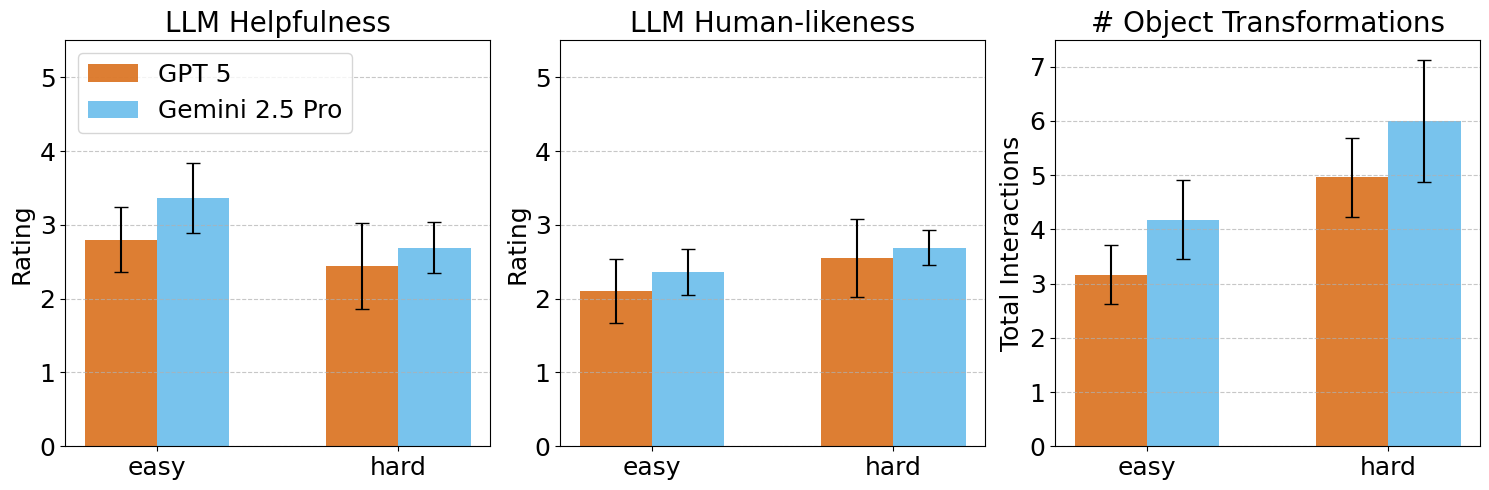

In [66]:
import polars as pl
import matplotlib.pyplot as plt
import numpy as np
import math

def make_plots(df):
    # Key to label mapping
    key_to_label = dict(
        small='easy',
        high='hard'
    )
    
    # Get unique models and experiments
    models = df["model_chosen"].unique().to_list()
    models = sorted(models)
    experiments = ['small', 'high']
    
    # Model name mapping
    model_display_names = {
        models[0]: "GPT 5",
        models[1]: "Gemini 2.5 Pro",
    }
    
    # Set up the plot with 3 columns (subplots)
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Width of bars and positions
    bar_width = 0.3
    n_experiments = len(experiments)
    n_models = len(models)
    
    # Position bars - center them around each experiment position
    x_positions = np.arange(n_experiments)
    
    # Colors for different models
    nice_colors = {
        "orange": (230 / 255, 159 / 255, 0.0),
        "vermillion": (213 / 255, 94 / 255, 0.0),
        "sky blue": (86 / 255, 180 / 255, 233 / 255),
        "bluish green": (0.0, 158 / 255, 115 / 255),
    }
    colors = [
        nice_colors["vermillion"],
        nice_colors["sky blue"],
    ]
    
    # Font sizes
    small_font_size = 18
    title_size = 20
    tick_size = 18
    axis_label_size = 18
    
    # Function to get data for each metric
    def get_metric_data(metric_col, stage_filter=True):
        vals_by_model = {}
        errs_by_model = {}
        
        for model in models:
            vals = []
            errs = []
            
            for exp in experiments:
                if stage_filter:
                    model_data = df.filter(
                        (pl.col("experiment") == exp) & 
                        (pl.col("model_chosen") == model) & 
                        (pl.col("stage_type") == "feedback")
                    )
                else:
                    model_data = df.filter(
                        (pl.col("experiment") == exp) & 
                        (pl.col("model_chosen") == model)
                    )
                
                values = model_data[metric_col].drop_nulls()
                
                if len(values) > 0:
                    mean_val = values.mean()
                    std_val = values.std()
                    err = std_val / math.sqrt(len(values)) if len(values) > 1 else 0
                else:
                    mean_val = 0
                    err = 0
                
                vals.append(mean_val)
                errs.append(err)
            
            vals_by_model[model] = vals
            errs_by_model[model] = errs
        
        return vals_by_model, errs_by_model
    
    # Get data for all metrics
    help_vals, help_errs = get_metric_data("How helpful was the AI?")
    human_vals, human_errs = get_metric_data("How human-like was the AI?")
    reward_vals, reward_errs = get_metric_data("transformations", stage_filter=False)
    
    # Plot each metric
    metrics = [
        (help_vals, help_errs, "LLM Helpfulness", "Rating", [0, 5.5]),
        (human_vals, human_errs, "LLM Human-likeness", "Rating", [0, 5.5]),
        (reward_vals, reward_errs, "# Object Transformations", "Total Interactions", None)
    ]
    
    for i, (vals_dict, errs_dict, title, ylabel, ylim) in enumerate(metrics):
        ax = axes[i]
        
        # Plot bars for each model
        for j, model in enumerate(models):
            offset = (j - 0.5) * bar_width
            x_pos = x_positions + offset
            
            bars = ax.bar(
                x_pos, 
                vals_dict[model], 
                bar_width, 
                color=colors[j],
                yerr=errs_dict[model], 
                capsize=5,
                alpha=0.8,
                label=model_display_names[model]
            )
        
        ax.set_title(title, fontsize=title_size)
        ax.set_ylabel(ylabel, fontsize=axis_label_size)
        ax.set_xticks(x_positions)
        ax.set_xticklabels([key_to_label[exp] for exp in experiments], fontsize=small_font_size)
        ax.tick_params(axis="both", which="major", labelsize=tick_size)
        ax.grid(axis="y", linestyle="--", alpha=0.7)
        
        if ylim:
            ax.set_ylim(ylim)
        
        # Add legend to first subplot
        if i == 0:
            ax.legend(fontsize=small_font_size, loc='upper left')
    
    # Adjust layout
    plt.tight_layout()
    plt.savefig("model_comparison.pdf", format="pdf", dpi=300, bbox_inches="tight")
    plt.show()

# Call the function with the full dataframe
make_plots(df)

In [48]:
df.filter(experiment='high', )

user_id,model_chosen,experiment,stage_type,How helpful was the AI?,How human-like was the AI?,total_reward,success,reaction_times,transformations
i64,str,str,str,i64,i64,f64,f64,str,f64
1037910819,"""gemini""","""high""","""interaction""",null,null,0.0,0.0,"""[ 4766. 1437. 3596. 831. …",13.0
1037910819,"""gemini""","""high""","""interaction""",null,null,0.0,0.0,"""[26178. 1169. 699. 255. …",17.0
1037910819,"""gemini""","""high""","""interaction""",null,null,0.0,0.0,"""[19756. 503. 251. 810. …",9.0
1639036403,"""gemini""","""high""","""interaction""",null,null,0.0,0.0,"""[68734. 472. 430. 361. …",9.0
1639036403,"""gemini""","""high""","""interaction""",null,null,0.0,0.0,"""[ 54928. 405. 370. 31…",9.0
…,…,…,…,…,…,…,…,…,…
695785369,"""gemini""","""high""","""interaction""",null,null,0.0,0.0,"""[21348. 561. 2672. 3300. …",5.0
695785369,"""gemini""","""high""","""interaction""",null,null,0.0,0.0,"""[49732. 1545. 559. 281. …",6.0
745319634,"""gemini""","""high""","""interaction""",null,null,0.0,0.0,"""[15276. 2621. 847. 1394. …",4.0
